In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.linalg as la
from matplotlib.font_manager import FontProperties

# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径
import sys
sys.path.append(r"C:\Users\haokw\Documents\GitHub\gaolu\MPC\高炉")


import base 
import rvfln.bls


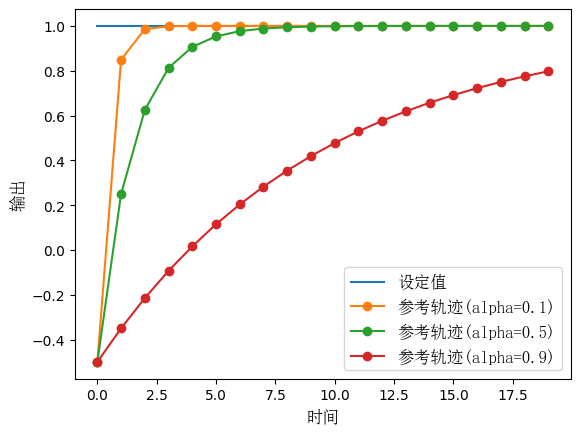

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def get_yr(aim_value, current_value, alpha, P, rous):
    # 生成设定信号
    setpoint_signal = np.full(10, aim_value)
    # 初始化参数
    alpha = alpha
    y_r_values = []
    # 模拟一阶模型
    for rou in rous:
        y_r = np.zeros(P)
        y_r[0] = current_value
        for k in range(1, P):
            y_r[k] = rou * y_r[k-1] + (1 - rou) * aim_value
        y_r_values.append(y_r)

    # 绘制结果
    plt.plot(setpoint_signal, label='设定值') 
    for i, y_r in enumerate(y_r_values):
        plt.plot(y_r, 'o-', label=f'参考轨迹(alpha={rous[i]})') 
        
    plt.legend(prop=font)  # 添加图例并设置字体为中文
    plt.xlabel('时间', fontproperties=font) 
    plt.ylabel('输出', fontproperties=font) 
    plt.show()

    return y_r_values

# 测试
rous = [0.1, 0.5, 0.9]
y_r_values = get_yr(1, -0.5, alpha=0.1, P=20, rous=rous)


In [3]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\新输入输出模式\\1h_mean.xlsx'
df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='原始输出') 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='剔除直线输出') 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='单SI_0.2_0.8') 
# print(df_sheet_yuansu.info())
# print(df_sheet_yuansu.columns)

excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\新输入输出模式\\1h_mean.xlsx'
df_sheet_params = pd.read_excel(excel_path, sheet_name='1h_mean_all') 

# print(df_sheet_params.info())
# print(df_sheet_params.columns)



In [4]:
import pandas as pd

# 假设 df 是你的 DataFrame

# 检查 DataFrame 中是否包含 NaN 值
contains_nan = df_sheet_yuansu.isna().any().any()

if contains_nan:
    print("数据包含 NaN 值")
else:
    print("数据不包含 NaN 值")
    # 检查 DataFrame 中是否包含 NaN 值
contains_nan = df_sheet_params.isna().any().any()

if contains_nan:
    print("数据包含 NaN 值")
else:
    print("数据不包含 NaN 值")


数据不包含 NaN 值
数据不包含 NaN 值


In [5]:
# 定义输入输出参数     '富氧流量', '冷风流量', '热风压力', '冷风压力', '热风温度', '鼓风湿度', '设定喷煤量'
input_term =        ['富氧流量', '设定喷煤量', '热风压力', '热风温度']
output_term = ['铁水温度[MIT]', '铁水硅含量[SI]']
time_term= '时间戳h'


C:\Users\haokw\AppData\Local\Temp\ipykernel_13940\2804243629.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_13940\2804243629.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_13940\2804243629.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haok

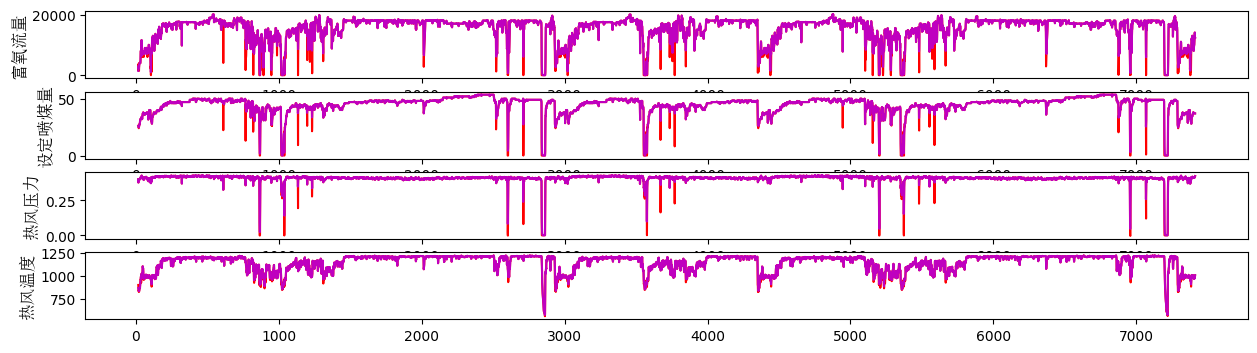

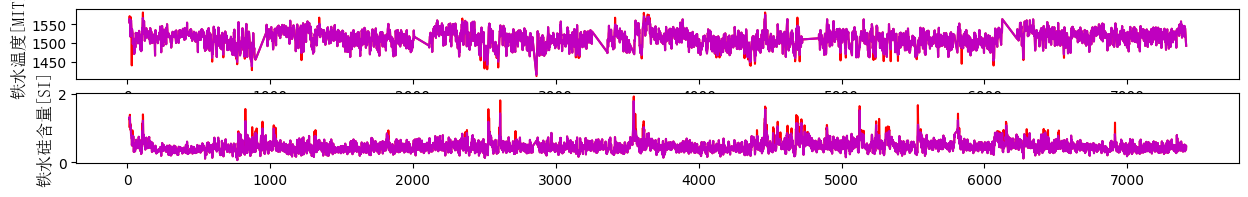

In [6]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_yuansu_process = df_sheet_yuansu.copy()
df_sheet_params_process = df_sheet_params.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 2.5 * y.std()
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value

# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[0]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[1]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[2]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[3]])

replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[0]])
replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[1]])

plt.figure(figsize=(15, 4))
for idx, column in enumerate(input_term):
    plt.subplot(len(input_term), 1, idx+1)
    plot_subplot(df_sheet_params_process[time_term].values,df_sheet_params[column].values,df_sheet_params_process[column].values,column)

plt.figure(figsize=(15, 2))
for idx, column in enumerate(output_term):
    plt.subplot(len(output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu[column].values,df_sheet_yuansu_process[column].values,column)




In [7]:
input_term222 =        ['富氧流量/(m\u00b3/h)', '设定喷煤量/(t/h)', '热风压力/kPa', '热风温度/℃']
output_term222 = ['铁水温度MIT/℃', '铁水硅含量[Si]/%']
time_term= '时间戳h'
print(input_term222)
print(output_term222)


['富氧流量/(m³/h)', '设定喷煤量/(t/h)', '热风压力/kPa', '热风温度/℃']
['铁水温度MIT/℃', '铁水硅含量[Si]/%']


In [8]:
c


['富氧流量', '设定喷煤量', '热风压力', '热风温度']
['铁水温度MIT', '铁水硅含量[Si]']


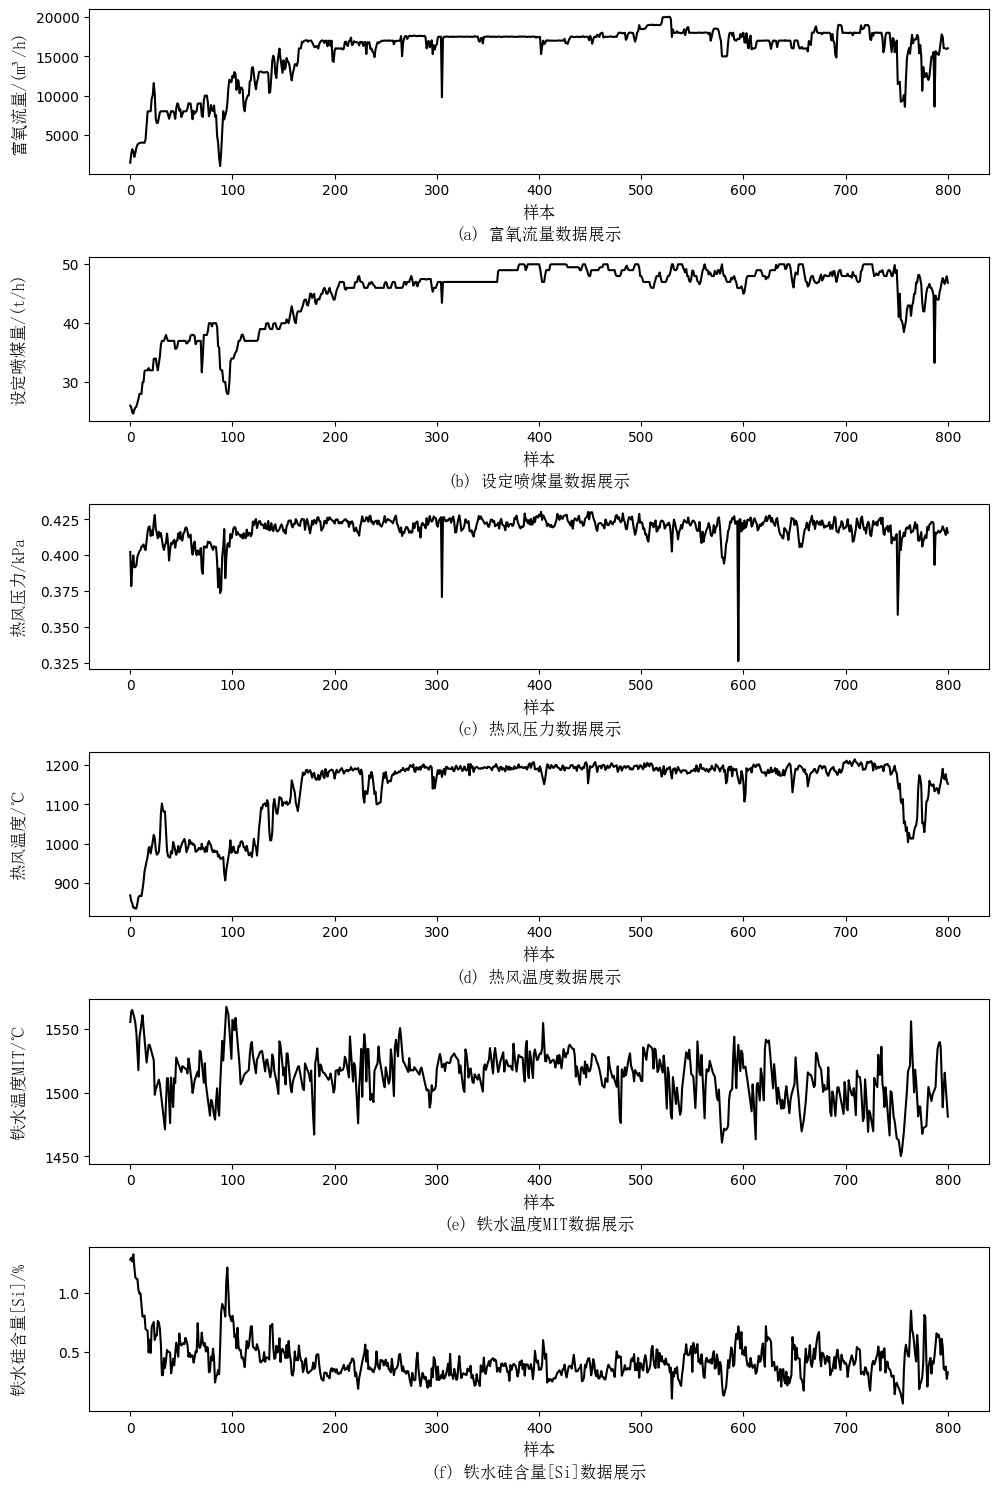

In [70]:
import matplotlib.pyplot as plt

def plot_subplot2222(data_y, column, index_gaolu):
    plt.plot(data_y[index_gaolu], 'k')
    plt.ylabel(column, fontproperties=font)  # 使用中文标签

length1 = 800
start1 = 0

index_gaolu = range(start1, start1 + length1 + 1, 1)

fig = plt.figure(figsize=(10, 15))

# 用于子图编号的字母序列
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

# Input term plots
for idx, column in enumerate(input_term):
    ax = plt.subplot(len(input_term) + len(output_term), 1, idx + 1)
    plot_subplot2222(df_sheet_params_process[column].values, input_term222[idx], index_gaolu)
    ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边
    ax.text(0.5, -0.4, f'{subplot_labels[idx]} {input_term333[idx]}数据展示', 
            transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
    # 添加横坐标标题
    ax.set_xlabel('样本', fontproperties=font)  # 只给最下面的子图添加横坐标标签

# Output term plots
for idx, column in enumerate(output_term):
    ax = plt.subplot(len(input_term) + len(output_term), 1, idx + 1 + len(input_term))
    plot_subplot2222(df_sheet_yuansu_process[column].values, output_term222[idx], index_gaolu)
    ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边
    ax.text(0.5, -0.4, f'{subplot_labels[idx + len(input_term)]} {output_term333[idx]}数据展示', 
            transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
    # 添加横坐标标题
    ax.set_xlabel('样本', fontproperties=font)  # 只给最下面的子图添加横坐标标签



# 调整子图之间的间距
plt.tight_layout()

plt.show()


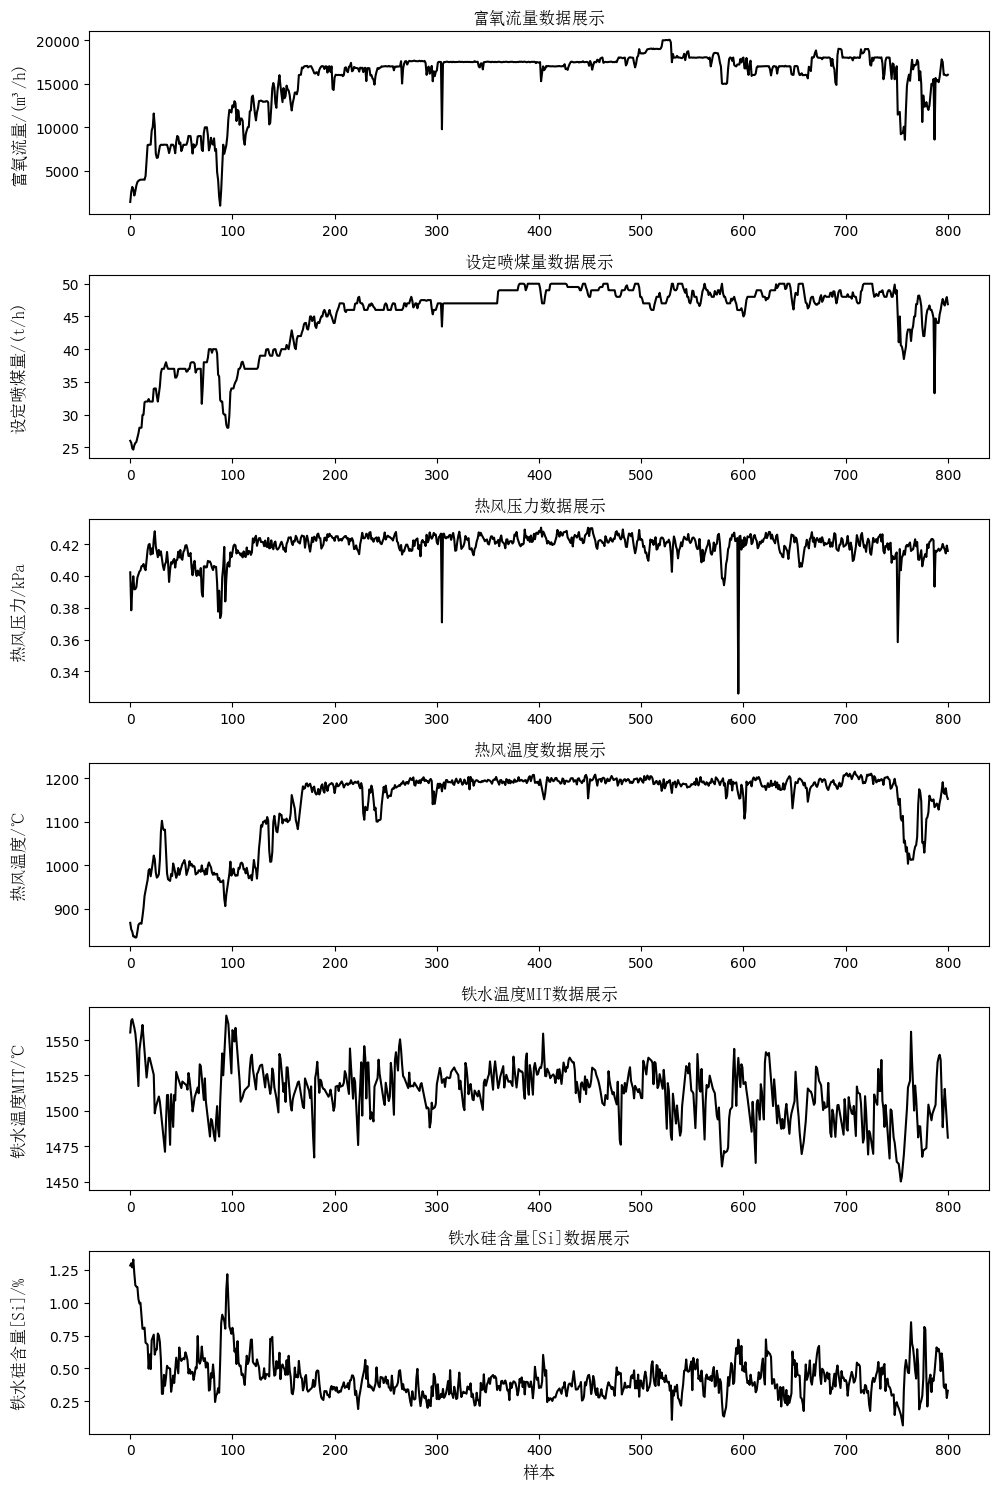

In [10]:
# 画出选取的数据
def plot_subplot2222(data_y,column,index_gaolu):
    plt.plot(data_y[index_gaolu],'k')

    plt.ylabel(column, fontproperties=font)   # 使用中文标签



length1 = 800
start1 = 0


index_gaolu   = range(start1, start1+length1+1, 1)



plt.figure(figsize=(10, 15))

for idx, column in enumerate(input_term):
    ax = plt.subplot(len(input_term + output_term), 1, idx + 1)
    plot_subplot2222(df_sheet_params_process[column].values,input_term222[idx],index_gaolu)
    ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边
    ax.set_title(f'{input_term333[idx]}数据展示', fontproperties=font)  # 添加每个子图的标题


for idx, column in enumerate(output_term):
    ax = plt.subplot(len(input_term + output_term), 1, idx + 1 + 4)
    plot_subplot2222(df_sheet_yuansu_process[column].values,output_term222[idx],index_gaolu)
    ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边
    ax.set_title(f'{output_term333[idx]}数据展示', fontproperties=font)  # 添加每个子图的标题

ax.set_xlabel('样本', fontproperties=font)  # 只给最下面的子图添加横坐标标签
plt.tight_layout()



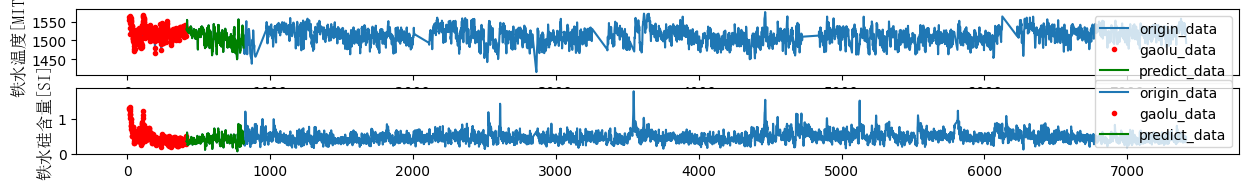

In [11]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-', label='origin_data')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'r.', label='gaolu_data')
    plt.plot(data_x[index_predict],data_y[index_predict],'g-', label='predict_data')
    plt.legend()
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签



length1 = 400
start1 = 0
length2 = 400
start2 = 400


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 6))
for idx, column in enumerate(output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu_process[column].values,column,index_predict,index_gaolu)



In [12]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_params_process[input_term[0]].values,
    input_term[1]:   df_sheet_params_process[input_term[1]].values,
    input_term[2]:   df_sheet_params_process[input_term[2]].values,
    input_term[3]:   df_sheet_params_process[input_term[3]].values,
    output_term[0]:  df_sheet_yuansu_process[output_term[0]].values,
    output_term[1]:  df_sheet_yuansu_process[output_term[1]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [13]:
# 标定归一化前后数据
data_point = np.array([1500]).reshape(-1, 1)
data1 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

data_point = np.array([1510]).reshape(-1, 1)
data3 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_temp = (data3-data1)/(data4-data2)
print('每摄氏度的输出差：',d_temp)



data_point = np.array([0.50]).reshape(-1, 1)
data1 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

data_point = np.array([0.60]).reshape(-1, 1)
data3 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_yuansu = (data3-data1)/(data4-data2)
print('每浓度的输出差：',(data3-data1))


[0.05346536]
[1500.]
[0.17902207]
[1510.]
每摄氏度的输出差： [0.01255567]
[-0.49612083]
[0.5]
[-0.38007579]
[0.6]
每浓度的输出差： [0.11604504]


In [14]:
isShuffle = True
isShuffle = False
time_steps = 2

test_size = 0.15
val_size = 0.15
train_size = 1-val_size-test_size


In [15]:
# 组合训练数据--拆分训练、测试集

# 定义时间步数和特征数

# 构成    
# X = [X(t),X(t-1),Y(t-1)]
# Y = [Y(t)]
def make_data(u1_data,u2_data,u3_data,u4_data,y1_data,y2_data,index_fanwei):
    X = np.column_stack((u1_data,u2_data,u3_data,u4_data))
    y = np.column_stack((y1_data, y2_data))

    X_modified = []
    y_modified = []
    
    for i in range(3,len(y1_data)):
        if i in index_fanwei:
            # print(i)
            # print(df_sheet_yuansu[time_term][i])
            yuansu_time = df_sheet_yuansu[time_term][i]
            closest_10 = df_sheet_params[df_sheet_params[time_term] <= yuansu_time].nlargest(time_steps, time_term)
            # print(closest_10)
            
            index = closest_10.index
            # print(index)
            # print(closest_10.iloc[-1][time_term])
            if closest_10.iloc[-1][time_term] < yuansu_time - time_steps + 1:
                print(i,yuansu_time,'errloss')
            else:

                # print(X[index, :])
                new_x_sample = np.concatenate([X[i, :] for i in index],axis=0)
                # print(new_x_sample)
                y_last = y[i-1, :]
                # print(y_last, 'y_last time : ',df_sheet_yuansu[time_term][i-1])
                new_x_sample = np.concatenate([new_x_sample,y_last],axis=0)
                # print(new_x_sample)
                y_sample = y[i, :]  
                X_modified.append(new_x_sample)
                y_modified.append(y_sample)
                print(i,yuansu_time,index[0],index[-1], end='\r')
                # break

    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)
    X_reshaped = X_modified.reshape((X_modified.shape[0], X_modified.shape[1]))

    # 打印新数据的形状
    print("Modified Input Shape:", X_reshaped.shape)
    print("Modified Output Shape:", y_modified.shape)


    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [16]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = normalized_data_dict[output_term[1]]
num_samples = y2_data.shape[0]

# filter_windows = 2
# u1_data = symmetrical_moving_average(u1_data, filter_windows)
# u2_data = symmetrical_moving_average(u2_data, filter_windows)
# u3_data = symmetrical_moving_average(u3_data, filter_windows)
# u4_data = symmetrical_moving_average(u4_data, filter_windows)
# y1_data = symmetrical_moving_average(y1_data, filter_windows)
# y2_data = symmetrical_moving_average(y2_data, filter_windows)

print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_gaolu)



# 预测模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = normalized_data_dict[output_term[1]]
num_samples = y2_data.shape[0]

print('预测模型数据')
X_predict_train, X_predict_val, X_predict_test,\
y_predict_train, y_predict_val, y_predict_test = make_data(u1_data,u2_data,u3_data,u4_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_gaolu)



高炉模型数据
Modified Input Shape: (398, 10)
Modified Output Shape: (398, 2)
训练数量： (278, 10) (278, 2)
验证数量： (60, 10) (60, 2)
测试数量： (60, 10) (60, 2)
预测模型数据
Modified Input Shape: (398, 10)
Modified Output Shape: (398, 2)
训练数量： (278, 10) (278, 2)
验证数量： (60, 10) (60, 2)
测试数量： (60, 10) (60, 2)


In [17]:
epoch_once_time = 60
ischuangxin = True
ischuangxin = False


神经网络

In [18]:
# 定义MyNeuralNetwork模型
import torch
import torch.nn as nn
import torch.optim as optim

class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,if_chuangxin):
        super(MyNeuralNetwork, self).__init__()
        self.if_chuangxin = if_chuangxin
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

    #     if self.if_chuangxin:            
    #         self.fc1 = nn.Linear(input_size, hidden_size)
    #         self.relu = nn.ReLU()
    #         self.fc2 = nn.Linear(hidden_size, hidden_size)
    #         self.fc3 = nn.Linear(hidden_size, output_size)
    #     else:
    #         self.fc1 = nn.Linear(input_size, hidden_size)
    #         self.fc2 = nn.Linear(hidden_size, hidden_size)
    #         self.fc3 = nn.Linear(hidden_size, output_size)
    #         self.relu = nn.ReLU()

    # def forward(self, x0):
    #     if self.if_chuangxin:

    #         x = self.fc1(x0)
    #         x = self.relu(x)

    #         x2 = self.fc2(x)
    #         x2 = self.relu(x2)

    #         x3 = x + x2
    #         output = self.fc3(x3)
    #     else:
    #         x = self.fc1(x0)
    #         x = self.relu(x)

    #         x2 = self.fc2(x)
    #         x2 = self.relu(x2)

    #         output = self.fc3(x2)
    #     return output

    def custom_loss(self, y_true, y_pred):
        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse



    def my_fit(self, 
                X_train, y_train, 
                X_val, y_val, 
                train_loss_list,val_loss_list,
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)


        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            # 验证集评估
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for i in range(0, len(X_val), batch_size):
                    x_batch_val = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                    y_batch_val = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                    y_pred_val = self(x_batch_val)
                    val_loss += self.custom_loss(y_batch_val, y_pred_val).item()

                average_epoch_val_loss = val_loss / (len(X_val) / batch_size)

            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}, 验证误差: {average_epoch_val_loss:.4f}', end='\r')
            train_loss_list.append(average_epoch_train_loss)
            val_loss_list.append(average_epoch_val_loss)

        return train_loss_list,val_loss_list
    
    

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred[:,0].detach().numpy(),y_pred[:,1].detach().numpy()


In [19]:
# 建立高炉模型实例
input_size = 10  # 10
hidden_size = 20  # 隐藏层大小
output_size = 2  # 输出大小

# 设置随机种子
torch.manual_seed(0)
NeuralNetwork_model_gaolu = MyNeuralNetwork(input_size, hidden_size, output_size,ischuangxin)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []





第 60/60 轮, 训练误差: 0.0257, 验证误差: 0.0165
epoch_sum: 60


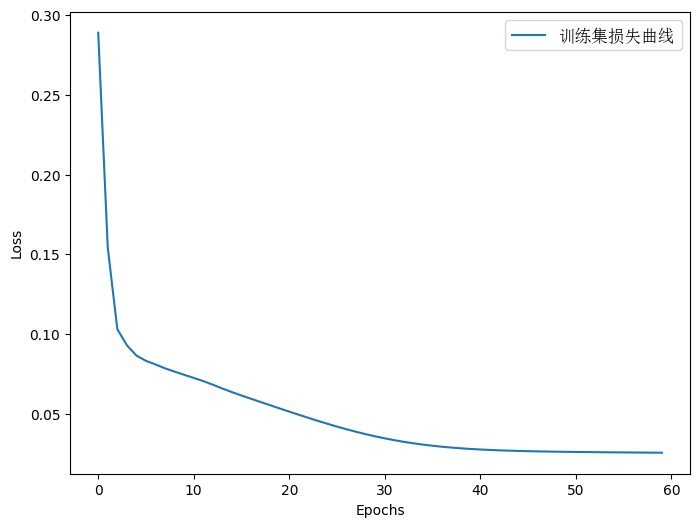

In [20]:
# 高炉模型训练
epoch_once = epoch_once_time
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = NeuralNetwork_model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=32,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线

plt.figure(figsize=(8, 6))
plt.plot(gaolu_train_loss_list, label='训练集损失曲线')
# plt.plot(gaolu_val_loss_list, label='验证集损失曲线')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(prop=font)
plt.show()


训练集
RMSE:  铁水温度[MIT]: 10.5426 , 铁水硅含量[SI]: 0.0734 
MAE :  铁水温度[MIT]: 7.7965% , 铁水硅含量[SI]: 0.0558%
MRE :  铁水温度[MIT]: 0.0051  , 铁水硅含量[SI]: 0.1210 
per :  铁水温度[MIT]: 0.7266  , 铁水硅含量[SI]: 0.8525 
测试集
RMSE:  铁水温度[MIT]: 7.4358 , 铁水硅含量[SI]: 0.0516 
MAE :  铁水温度[MIT]: 5.5973% , 铁水硅含量[SI]: 0.0400%
MRE :  铁水温度[MIT]: 0.0037  , 铁水硅含量[SI]: 0.1092 
per :  铁水温度[MIT]: 0.8167  , 铁水硅含量[SI]: 0.9500 


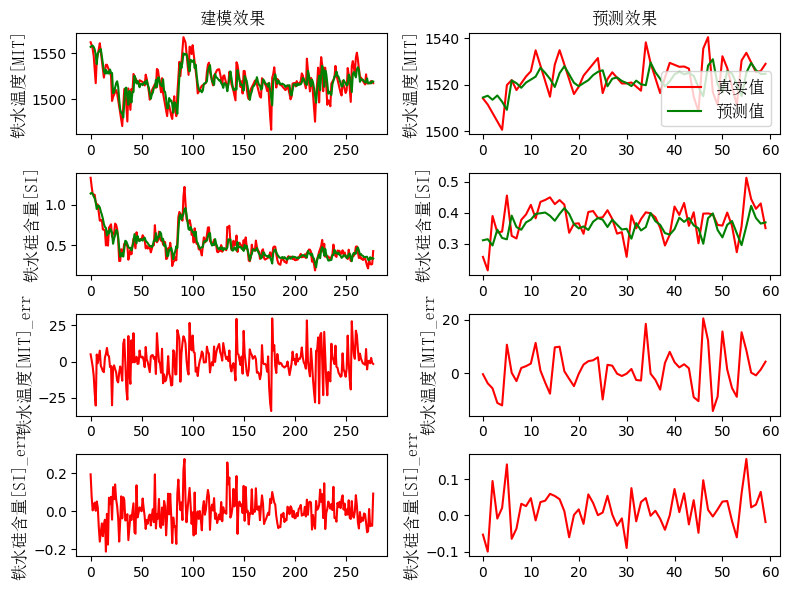

In [21]:
# 高炉模型建模效果
NeuralNetwork_y_train_pred_0,NeuralNetwork_y_train_pred_1 = NeuralNetwork_model_gaolu.my_predict(X_gaolu_train)
NeuralNetwork_y_test_pred_0,NeuralNetwork_y_test_pred_1 = NeuralNetwork_model_gaolu.my_predict(X_gaolu_test)

base.double_control_train_test_result(scalers,  output_term,
                                        y_predict_train,  NeuralNetwork_y_train_pred_0, NeuralNetwork_y_train_pred_1,
                                        y_predict_test ,  NeuralNetwork_y_test_pred_0 , NeuralNetwork_y_test_pred_1)


# base.double_control_train_test_result(scalers,  output_term,
#                                         y_predict_train[:-1],  NeuralNetwork_y_train_pred_0[1:], NeuralNetwork_y_train_pred_1[1:],
#                                         y_predict_test[:-1] ,   NeuralNetwork_y_test_pred_0[1:],  NeuralNetwork_y_test_pred_1[1:])


SVR

In [22]:
# 定义My_LS_SVRModel
class My_M_LS_SVRModel:
    def __init__(self, params):
        C0, C1, C00, gamma= params
        self.C0 = C0
        self.C1 = C1
        self.C00 = C00
        self.gamma = gamma
        self.W_b = None
        self.X_train = None
    # 获取模型参数
    def get_params(self, W_b):

        mid_indix = W_b.shape[0]//2-1
        pred_0 = W_b[-2:-1]
        W0 = W_b[:mid_indix]
        b1 = W_b[-1:]
        W1 = W_b[mid_indix:mid_indix*2]
        W_b_0 = np.concatenate((W0, pred_0))
        W_b_1 = np.concatenate((W1, b1))
        # print(mid_indix)

        # print('pred_0:',pred_0.shape)
        # print('W0:',W0.shape)
        # print('b1:',b1.shape)
        # print('W1:',W1.shape)
        return pred_0,W0,b1,W1,W_b_0,W_b_1

    def model_train(self, X_train, y_train, K_train):
        def objective(W_b, X, y):
            b0,W0,b1,W1,W_b_0,W_b_1 = self.get_params(W_b)

            y_pred_0 = np.dot(K_train, W0) + b0
            y_pred_1 = np.dot(K_train, W1) + b1
            errors0 = y[:,0] - y_pred_0
            errors1 = y[:,1] - y_pred_1

            # 损失函数
            loss = ( 0.5 * (np.dot(W0, W0)+np.dot(W1, W1)) 
                    + self.C0 * np.sum(errors0**2) + self.C1 * np.sum(errors1**2)
                    + self.C00 * np.sum(errors0**2 + errors1**2) # L2 范数的平方
                    )
            return loss

        # 初始化权重向量+偏移项b
        # initial_W_b = np.zeros((10)*2+(1)*2)
        initial_W_b = np.zeros((X_train.shape[0])*2+(1)*2)

        # 使用minimize 函数最小化目标函数
        result = minimize(objective, initial_W_b, args=(X_train, y_train),
                            method='L-BFGS-B')
        # 输出最优的权重向量
        best_W_b = result.x
        return best_W_b

    def fit(self, X_train, y_train):
        self.X_train = X_train
        K_train = rbf_kernel(X_train, X_train, gamma=self.gamma)
        self.W_b = self.model_train(X_train, y_train, K_train)

    def my_predict(self, X_test):
        b0,W0,b1,W1,W_b_0,W_b_1 = self.get_params(self.W_b)
        K_test = rbf_kernel(X_test, self.X_train, gamma=self.gamma)
        y_pred_0 = np.dot(K_test, W0) + b0
        y_pred_1 = np.dot(K_test, W1) + b1
        return y_pred_0, y_pred_1
    


    

# # 示例用法
# params = [8.78525340e+01, 2.01347249e-03]
# # 创建模型
# my_svr_model = My_LS_SVRModel(params=params)
# # 训练模型
# my_svr_model.fit(X_train, y_train)
# # 模型预测
# y_pred = my_svr_model.predict(X_test)


In [23]:
# 创建模
params =   [1 , 500, 10 ,8] 
SVR_model_gaolu = My_M_LS_SVRModel(params=params)
# 训练模型
SVR_model_gaolu.fit(X_gaolu_train, y_gaolu_train)



训练集
RMSE:  铁水温度[MIT]: 13.1443 , 铁水硅含量[SI]: 0.0625 
MAE :  铁水温度[MIT]: 9.5425% , 铁水硅含量[SI]: 0.0487%
MRE :  铁水温度[MIT]: 0.0063  , 铁水硅含量[SI]: 0.1059 
per :  铁水温度[MIT]: 0.6403  , 铁水硅含量[SI]: 0.8993 
测试集
RMSE:  铁水温度[MIT]: 8.2690 , 铁水硅含量[SI]: 0.0697 
MAE :  铁水温度[MIT]: 6.2291% , 铁水硅含量[SI]: 0.0580%
MRE :  铁水温度[MIT]: 0.0041  , 铁水硅含量[SI]: 0.1655 
per :  铁水温度[MIT]: 0.8000  , 铁水硅含量[SI]: 0.8333 


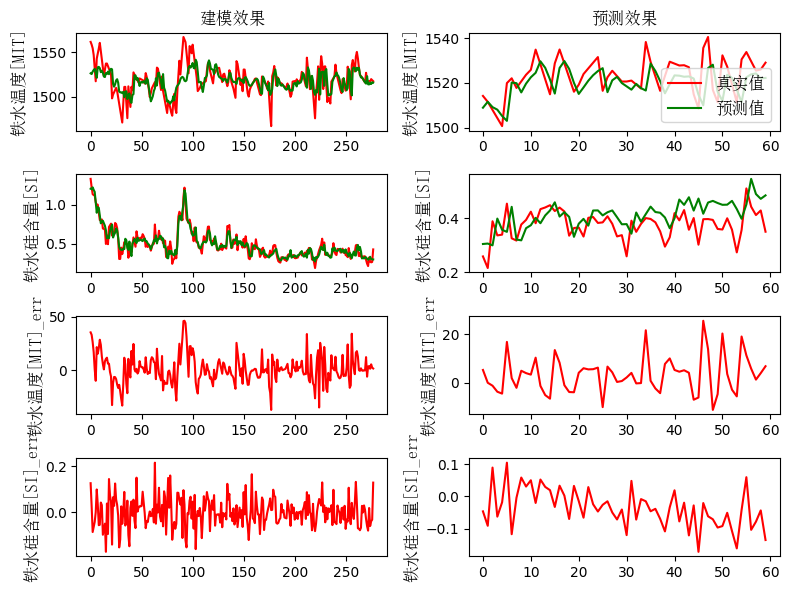

In [24]:
# 高炉模型预测
SVR_y_train_pred_0,SVR_y_train_pred_1 = SVR_model_gaolu.my_predict(X_gaolu_train)
SVR_y_test_pred_0,SVR_y_test_pred_1 = SVR_model_gaolu.my_predict(X_gaolu_test)

base.double_control_train_test_result(scalers,  output_term,
                                        y_predict_train,  SVR_y_train_pred_0, SVR_y_train_pred_1,
                                        y_predict_test,   SVR_y_test_pred_0,  SVR_y_test_pred_1)


BLS

In [25]:
BLS_model_gaolu = rvfln.bls.BLSRegressor(n_z = 5,
                            n_z_features = 16,
                            n_h = 5,
                            alpha = 0.10)
BLS_model_gaolu.fit(X_gaolu_train,y_gaolu_train)


BLSRegressor(alpha=0.1, n_h=5, n_z=5, n_z_features=16)

(0.5879964742332107, 0.898709716235065)
(-1.4620905702989928, -3.372450574680487)
训练集
RMSE:  铁水温度[MIT]: 9.2401 , 铁水硅含量[SI]: 0.0575 
MAE :  铁水温度[MIT]: 6.4965% , 铁水硅含量[SI]: 0.0453%
MRE :  铁水温度[MIT]: 0.0043  , 铁水硅含量[SI]: 0.0981 
per :  铁水温度[MIT]: 0.8129  , 铁水硅含量[SI]: 0.9137 
测试集
RMSE:  铁水温度[MIT]: 7.9083 , 铁水硅含量[SI]: 0.0627 
MAE :  铁水温度[MIT]: 6.1167% , 铁水硅含量[SI]: 0.0506%
MRE :  铁水温度[MIT]: 0.0040  , 铁水硅含量[SI]: 0.1317 
per :  铁水温度[MIT]: 0.8333  , 铁水硅含量[SI]: 0.9000 


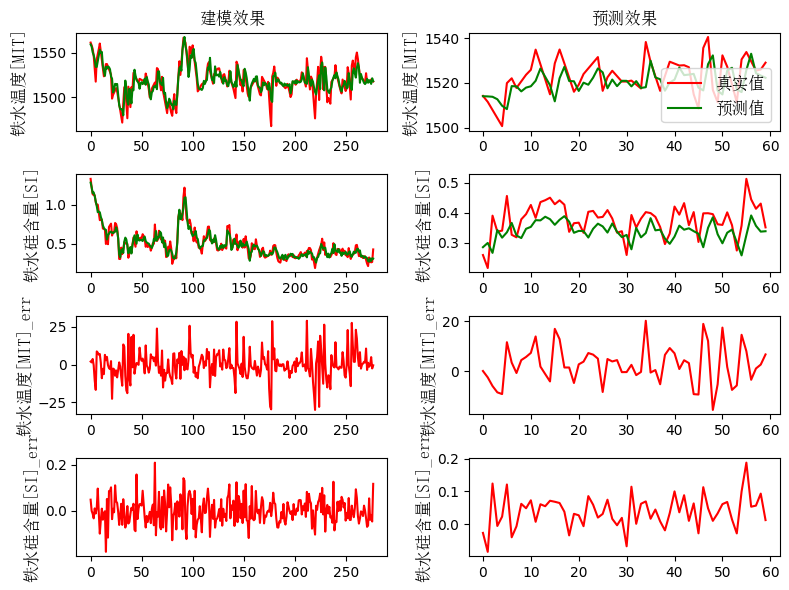

In [26]:
BLS_y_train_pred_0,BLS_y_train_pred_1 = BLS_model_gaolu.my_predict(X_gaolu_train)
BLS_y_test_pred_0,BLS_y_test_pred_1 = BLS_model_gaolu.my_predict(X_gaolu_test)

print(BLS_model_gaolu.score(X_gaolu_train,y_gaolu_train))
print(BLS_model_gaolu.score(X_gaolu_test,y_gaolu_test))


base.double_control_train_test_result(scalers,  output_term,
                                        y_predict_train,  BLS_y_train_pred_0, BLS_y_train_pred_1,
                                        y_predict_test,   BLS_y_test_pred_0,  BLS_y_test_pred_1)


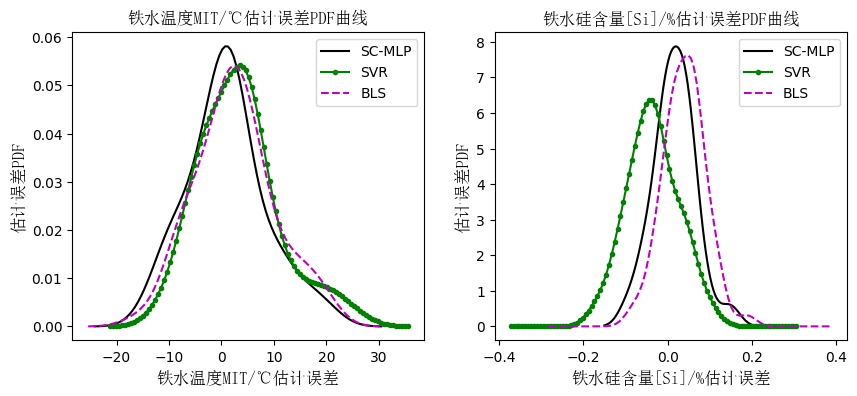

In [27]:
# PDF
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 示例数据

y_test_0 = scalers[output_term[0]].inverse_transform((y_predict_test[:, 0]).reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform((y_predict_test[:, 1]).reshape(-1, 1)).flatten()

NeuralNetwork_y_pred_0 = scalers[output_term[0]].inverse_transform((NeuralNetwork_y_test_pred_0).reshape(-1, 1)).flatten()
NeuralNetwork_y_pred_1 = scalers[output_term[1]].inverse_transform((NeuralNetwork_y_test_pred_1).reshape(-1, 1)).flatten()


SVR_y_pred_0 = scalers[output_term[0]].inverse_transform((SVR_y_test_pred_0).reshape(-1, 1)).flatten()
SVR_y_pred_1 = scalers[output_term[1]].inverse_transform((SVR_y_test_pred_1).reshape(-1, 1)).flatten()


BLS_y_pred_0 = scalers[output_term[0]].inverse_transform((BLS_y_test_pred_0).reshape(-1, 1)).flatten()
BLS_y_pred_1 = scalers[output_term[1]].inverse_transform((BLS_y_test_pred_1).reshape(-1, 1)).flatten()
# 计算误差
NeuralNetwork_y_error_0 = y_test_0 - NeuralNetwork_y_pred_0
NeuralNetwork_y_error_1 = y_test_1 - NeuralNetwork_y_pred_1


SVR_y_error_0 = y_test_0 - SVR_y_pred_0
SVR_y_error_1 = y_test_1 - SVR_y_pred_1

BLS_y_error_0 = y_test_0 - BLS_y_pred_0
BLS_y_error_1 = y_test_1 - BLS_y_pred_1


# 定义用于估计的函数
def plot_pdf_curve(data, label, linestyle):
    density = gaussian_kde(data)
    xs = np.linspace(min(data), max(data), 100)
    plt.plot(xs, density(xs), label=label, linestyle=linestyle)

# 绘制第一个图
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

data = NeuralNetwork_y_error_0
density = gaussian_kde(data)
xs = np.linspace(min(data)-10, max(data)+10, 100)
plt.plot(xs, density(xs),'k', label="SC-MLP")


data = SVR_y_error_0
density = gaussian_kde(data)
xs = np.linspace(min(data)-10, max(data)+10, 100)
plt.plot(xs, density(xs),'g.-', label="SVR")


data = BLS_y_error_0
density = gaussian_kde(data)
xs = np.linspace(min(data)-10, max(data)+10, 100)
plt.plot(xs, density(xs),'m--', label="BLS")
plt.title(f'{output_term222[0]}估计误差PDF曲线', fontproperties=font)  # 添加每个子图的标题
plt.xlabel(output_term222[0]+"估计误差", fontproperties=font)
plt.legend()
plt.ylabel("估计误差PDF", fontproperties=font) 

# 绘制第二个图
plt.subplot(1, 2, 2)

data = NeuralNetwork_y_error_1
density = gaussian_kde(data)
xs = np.linspace(min(data)-0.05, max(data)+0.05, 100)
plt.plot(xs, density(xs),'k', label="SC-MLP")


data = SVR_y_error_1
density = gaussian_kde(data)
xs = np.linspace(min(data)-0.2, max(data)+0.2, 100)

plt.plot(xs, density(xs),'g.-', label="SVR")

data = BLS_y_error_1
density = gaussian_kde(data)
xs = np.linspace(min(data)-0.2, max(data)+0.2, 100)
plt.plot(xs, density(xs),'m--', label="BLS")


plt.legend()
plt.title(f'{output_term222[1]}估计误差PDF曲线', fontproperties=font)  # 添加每个子图的标题
plt.xlabel(output_term222[1]+"估计误差", fontproperties=font)
plt.ylabel("估计误差PDF", fontproperties=font) 

plt.show()


In [28]:

# 用于子图编号的字母序列
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']


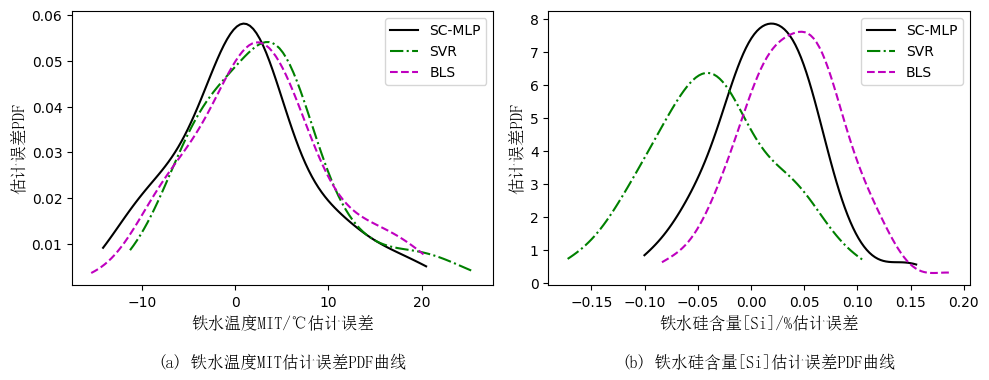

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 示例数据
# 请确保定义和赋值了scalers和数据数组

# 计算误差
NeuralNetwork_y_error_0 = y_test_0 - NeuralNetwork_y_pred_0
NeuralNetwork_y_error_1 = y_test_1 - NeuralNetwork_y_pred_1

SVR_y_error_0 = y_test_0 - SVR_y_pred_0
SVR_y_error_1 = y_test_1 - SVR_y_pred_1

BLS_y_error_0 = y_test_0 - BLS_y_pred_0
BLS_y_error_1 = y_test_1 - BLS_y_pred_1

# 定义用于估计的函数
def plot_pdf_curve(data, label, linestyle, color):
    density = gaussian_kde(data)
    xs = np.linspace(min(data), max(data), 100)
    plt.plot(xs, density(xs), linestyle=linestyle, color=color, label=label)

# 字母编号
subplot_labels = ['(a)', '(b)']

# 绘制误差PDF曲线
plt.figure(figsize=(10, 4))

# 绘制第一个图
ax1 = plt.subplot(1, 2, 1)

plot_pdf_curve(NeuralNetwork_y_error_0, "SC-MLP", '-', 'k')
plot_pdf_curve(SVR_y_error_0, "SVR", '-.', 'g')
plot_pdf_curve(BLS_y_error_0, "BLS", '--', 'm')

# ax1.set_title(f'{output_term222[0]}估计误差PDF曲线', fontproperties=font)
ax1.set_xlabel(f'{output_term222[0]}估计误差', fontproperties=font)
ax1.set_ylabel("估计误差PDF", fontproperties=font)
ax1.text(0.5, -0.3, f'{subplot_labels[0]} {output_term333[0]}估计误差PDF曲线', transform=ax1.transAxes, ha='center', fontproperties=font)
ax1.legend()

# 绘制第二个图
ax2 = plt.subplot(1, 2, 2)

plot_pdf_curve(NeuralNetwork_y_error_1, "SC-MLP", '-', 'k')
plot_pdf_curve(SVR_y_error_1, "SVR", '-.', 'g')
plot_pdf_curve(BLS_y_error_1, "BLS", '--', 'm')

# ax2.set_title(f'{output_term222[1]}估计误差PDF曲线', fontproperties=font)
ax2.set_xlabel(f'{output_term222[1]}估计误差', fontproperties=font)
ax2.set_ylabel("估计误差PDF", fontproperties=font)
ax2.text(0.5, -0.3, f'{subplot_labels[1]} {output_term333[1]}估计误差PDF曲线', transform=ax2.transAxes, ha='center', fontproperties=font)
ax2.legend()

plt.tight_layout()  # 调整布局以避免重叠
plt.show()


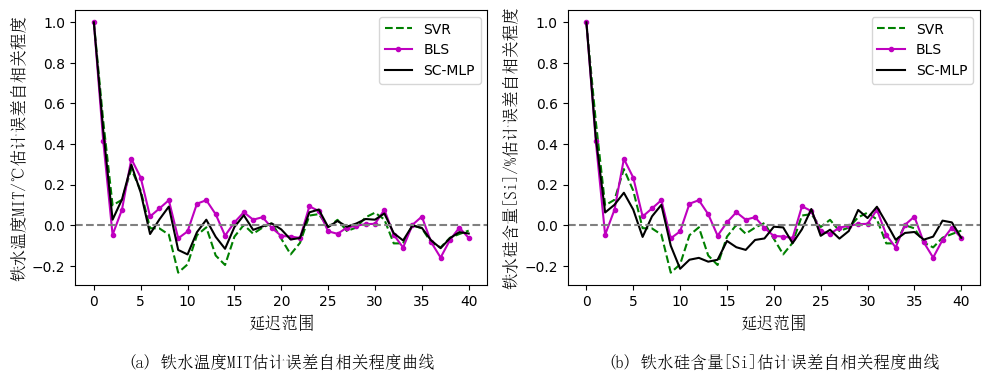

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# 计算自相关系数，nlags指定了要考虑的延迟数
nlags = 40  # 可以根据需要调整

# 子图标题
subplot_titles = [f'{output_term222[0]}估计误差自相关函数', f'{output_term222[1]}估计误差自相关函数']
# 绘制自相关函数曲线  
plt.figure(figsize=(10, 4))  


# 绘制自相关函数曲线
ax0 = plt.subplot(1, 2, 1)

# 第一个误差序列的自相关函数
acf_0, confint_0 = acf(SVR_y_pred_0, nlags=nlags, fft=False, alpha=0.05)
ax0.plot(acf_0, 'g--', label='SVR')

acf_0, confint_0 = acf(BLS_y_pred_0, nlags=nlags, fft=False, alpha=0.05)
ax0.plot(acf_0, 'm.-', label='BLS')

acf_0, confint_0 = acf(NeuralNetwork_y_pred_0, nlags=nlags, fft=False, alpha=0.05)
ax0.plot(acf_0, 'k', label='SC-MLP')

ax0.axhline(y=0, linestyle='--', color='gray')
ax0.set_xlabel('延迟范围', fontproperties=font)
ax0.set_ylabel(output_term222[0]+'估计误差自相关程度', fontproperties=font)
ax0.legend(loc='upper right')
ax0.text(0.5, -0.3, f'{subplot_labels[0]} {output_term333[0]}估计误差自相关程度曲线', transform=ax0.transAxes, ha='center', fontproperties=font)


ax1 = plt.subplot(1, 2, 2)

# 第二个误差序列的自相关函数
acf_1, confint_1 = acf(SVR_y_pred_0, nlags=nlags, fft=False, alpha=0.05)
ax1.plot(acf_1, 'g--', label='SVR')

acf_1, confint_1 = acf(BLS_y_pred_0, nlags=nlags, fft=False, alpha=0.05)
ax1.plot(acf_1, 'm.-', label='BLS')

acf_1, confint_1 = acf(NeuralNetwork_y_pred_1, nlags=nlags, fft=False, alpha=0.05)
ax1.plot(acf_1, 'k', label='SC-MLP')

ax1.axhline(y=0, linestyle='--', color='gray')
ax1.set_xlabel('延迟范围', fontproperties=font)
ax1.set_ylabel(output_term222[1]+'估计误差自相关程度', fontproperties=font)
ax1.legend(loc='upper right')
ax1.text(0.5, -0.3, f'{subplot_labels[1]} {output_term333[1]}估计误差自相关程度曲线', transform=ax1.transAxes, ha='center', fontproperties=font)

plt.tight_layout()
plt.show()


处理结果

建模效果

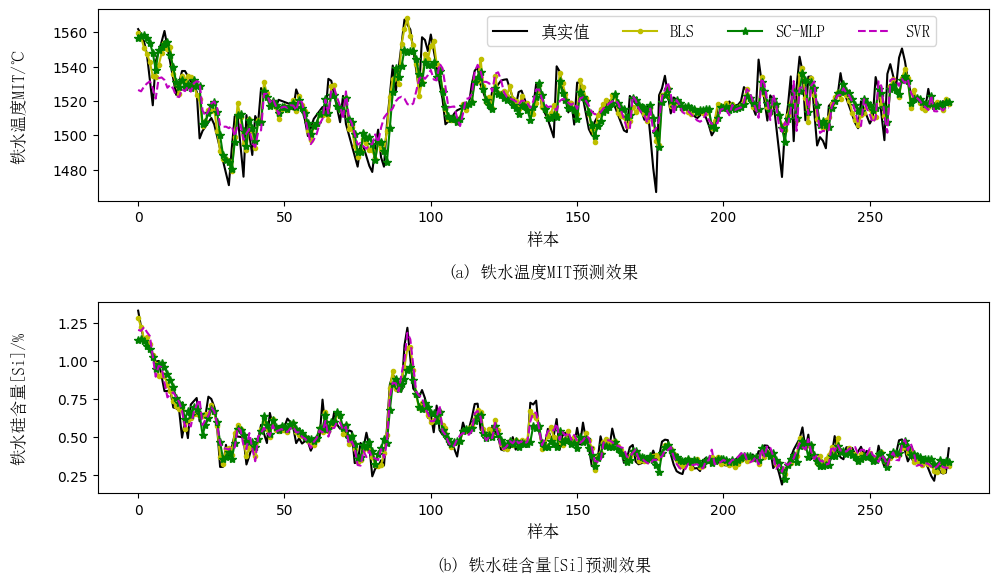

In [67]:
y_test = y_predict_train
y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()

NeuralNetwork_0 = scalers[output_term[0]].inverse_transform((NeuralNetwork_y_train_pred_0).reshape(-1, 1)).flatten()
NeuralNetwork_1 = scalers[output_term[1]].inverse_transform((NeuralNetwork_y_train_pred_1).reshape(-1, 1)).flatten()


SVR_0 = scalers[output_term[0]].inverse_transform((SVR_y_train_pred_0).reshape(-1, 1)).flatten()
SVR_1 = scalers[output_term[1]].inverse_transform((SVR_y_train_pred_1).reshape(-1, 1)).flatten()



BLS_0 = scalers[output_term[0]].inverse_transform((BLS_y_train_pred_0).reshape(-1, 1)).flatten()
BLS_1 = scalers[output_term[1]].inverse_transform((BLS_y_train_pred_1).reshape(-1, 1)).flatten()






plt.figure(figsize=(10, 6))

# 第一个子图
ax1 = plt.subplot(2, 1, 1)
plt.plot(y_test_0, 'k', label="真实值")  # 红色
plt.plot(BLS_0, 'y.-', label="BLS")  # 黄色
plt.plot(NeuralNetwork_0, 'g*-', label="SC-MLP")  # 绿色o
plt.plot(SVR_0, 'm--', label="SVR")  # 洋红色
plt.ylabel(output_term222[0], fontproperties=font)
plt.xlabel('样本', fontproperties=font)  # 添加横坐标标签
ax1.yaxis.set_label_coords(-0.08, 0.5)  # 固定纵坐标标签在最左边
# ax1.set_title("子图标题1", fontproperties=font,loc='center')  # 添加子图标题

ax1.text(0.5, -0.4, f'{subplot_labels[0]} {output_term333[0]}预测效果', transform=ax1.transAxes, ha='center', fontproperties=font)
# 添加图例，平铺在顶部
ax1.legend(prop=font, loc='upper right', bbox_to_anchor=(0.95, 1.01), ncol=4)



# 第二个子图
ax2 = plt.subplot(2, 1, 2)
plt.plot(y_test_1, 'k')
plt.plot(BLS_1, 'y.-')
plt.plot(NeuralNetwork_1, 'g*-')
plt.plot(SVR_1, 'm--')
plt.xlabel('样本', fontproperties=font)  # 添加横坐标标签
plt.ylabel(output_term222[1], fontproperties=font)
ax2.yaxis.set_label_coords(-0.08, 0.5)  # 固定纵坐标标签在最左边
# ax2.set_title("子图标题2", fontproperties=font)  # 添加子图标题
ax2.text(0.5, -0.4, f'{subplot_labels[1]} {output_term333[1]}预测效果', transform=ax2.transAxes, ha='center', fontproperties=font)

plt.tight_layout()
plt.show()



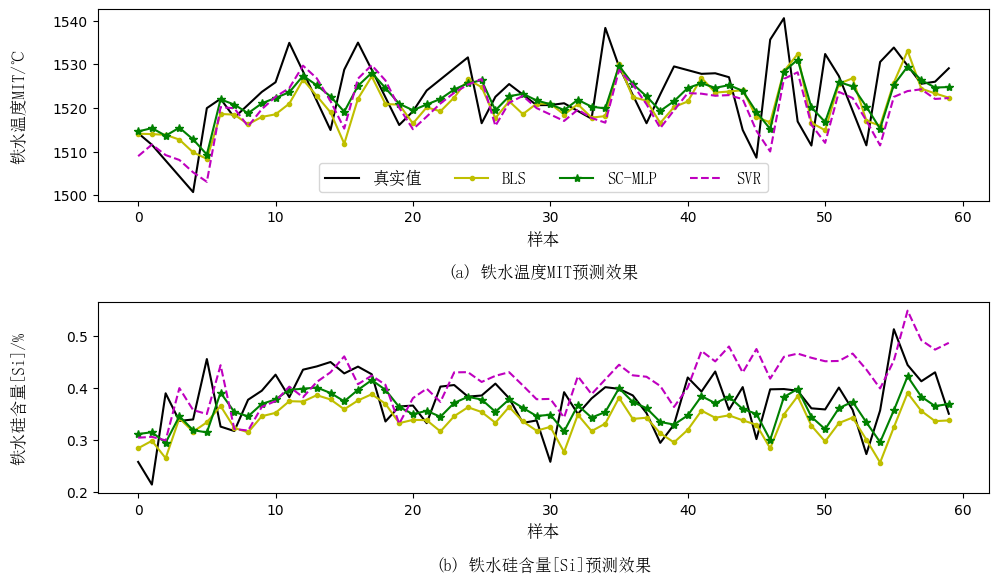

In [56]:
plt.figure(figsize=(10, 6))

# 第一个子图
ax1 = plt.subplot(2, 1, 1)
plt.plot(y_test_0, 'k', label="真实值")  # 红色
plt.plot(BLS_0, 'y.-', label="BLS")  # 黄色
plt.plot(NeuralNetwork_0, 'g*-', label="SC-MLP")  # 绿色o
plt.plot(SVR_0, 'm--', label="SVR")  # 洋红色
plt.ylabel(output_term222[0], fontproperties=font)
plt.xlabel('样本', fontproperties=font)  # 添加横坐标标签
ax1.yaxis.set_label_coords(-0.08, 0.5)  # 固定纵坐标标签在最左边
# ax1.set_title("子图标题1", fontproperties=font,loc='center')  # 添加子图标题

ax1.text(0.5, -0.4, f'{subplot_labels[0]} {output_term333[0]}预测效果', transform=ax1.transAxes, ha='center', fontproperties=font)
# 添加图例，平铺在顶部
ax1.legend(prop=font, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=4)



# 第二个子图
ax2 = plt.subplot(2, 1, 2)
plt.plot(y_test_1, 'k')
plt.plot(BLS_1, 'y.-')
plt.plot(NeuralNetwork_1, 'g*-')
plt.plot(SVR_1, 'm--')
plt.xlabel('样本', fontproperties=font)  # 添加横坐标标签
plt.ylabel(output_term222[1], fontproperties=font)
ax2.yaxis.set_label_coords(-0.08, 0.5)  # 固定纵坐标标签在最左边
# ax2.set_title("子图标题2", fontproperties=font)  # 添加子图标题
ax2.text(0.5, -0.4, f'{subplot_labels[1]} {output_term333[1]}预测效果', transform=ax2.transAxes, ha='center', fontproperties=font)

plt.tight_layout()
plt.show()


In [33]:
# plt.figure(figsize=(8, 6))
# plt.subplot(5, 2, 1)
# plt.plot(y_test_0,'r', label="真实值")
# plt.plot(NeuralNetwork_0,'b', label="NeuralNetwork")
# plt.ylabel(output_term[0], fontproperties=font)
# plt.legend(prop=font)
# plt.title("预测效果", fontproperties=font)

# plt.subplot(5, 2, 3)
# plt.plot(y_test_0,'r', label="真实值")
# # plt.plot(LSTM_0,'b', label="LSTM")
# plt.ylabel(output_term[0], fontproperties=font)
# plt.legend(prop=font)

# plt.subplot(5, 2, 5)
# plt.plot(y_test_0,'r', label="真实值")
# plt.plot(REFLNS_0,'b', label="REFLNS")
# plt.ylabel(output_term[0], fontproperties=font)
# plt.legend(prop=font)

# plt.subplot(5, 2, 7)
# plt.plot(y_test_0,'r', label="真实值")
# plt.plot(SVR_0,'b', label="SVR")
# plt.ylabel(output_term[0], fontproperties=font)
# plt.legend(prop=font)

# plt.subplot(5, 2, 9)
# plt.plot(y_test_0,'r', label="真实值")
# plt.plot(BLS_0,'b', label="BLS")
# plt.ylabel(output_term[0], fontproperties=font)
# plt.legend(prop=font)



# plt.subplot(5, 2, 2)
# plt.plot(y_test_1,'r', label="真实值")
# plt.plot(NeuralNetwork_1,'b', label="NeuralNetwork")
# plt.ylabel(output_term[0], fontproperties=font)
# plt.legend(prop=font)

# plt.subplot(5, 2, 4)
# plt.plot(y_test_1,'r', label="真实值")
# # plt.plot(LSTM_1,'b', label="LSTM")
# plt.ylabel(output_term[0], fontproperties=font)
# plt.legend(prop=font)

# plt.subplot(5, 2, 6)
# plt.plot(y_test_1,'r', label="真实值")
# plt.plot(REFLNS_1,'b', label="REFLNS")
# plt.ylabel(output_term[0], fontproperties=font)
# plt.legend(prop=font)

# plt.subplot(5, 2, 8)
# plt.plot(y_test_1,'r', label="真实值")
# plt.plot(SVR_1,'b', label="SVR")
# plt.ylabel(output_term[0], fontproperties=font)
# plt.legend(prop=font)

# plt.subplot(5, 2, 10)
# plt.plot(y_test_1,'r', label="真实值")
# plt.plot(BLS_1,'b', label="BLS")
# plt.ylabel(output_term[0], fontproperties=font)
# plt.legend(prop=font)




预测效果

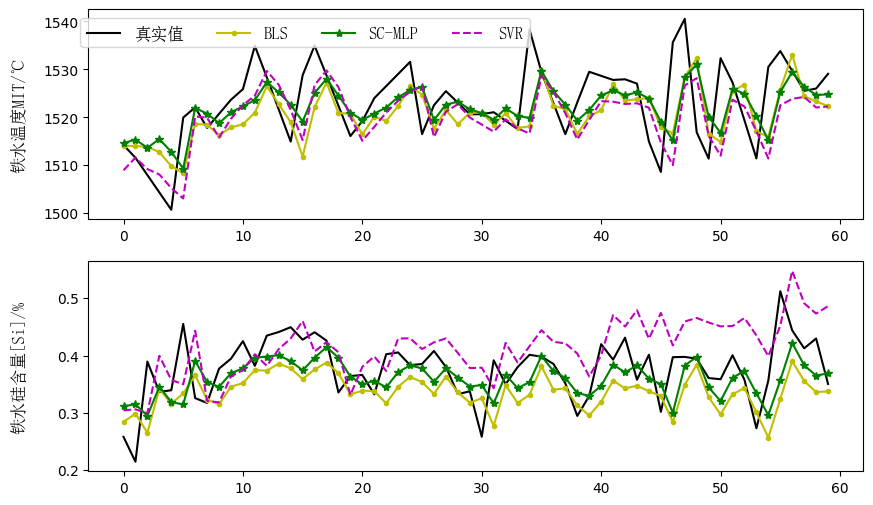

In [34]:
y_test = y_gaolu_test
y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()

NeuralNetwork_0 = scalers[output_term[0]].inverse_transform((NeuralNetwork_y_test_pred_0).reshape(-1, 1)).flatten()
NeuralNetwork_1 = scalers[output_term[1]].inverse_transform((NeuralNetwork_y_test_pred_1).reshape(-1, 1)).flatten()


# LSTM_0 = scalers[output_term[0]].inverse_transform((LSTM_y_test_pred_0).reshape(-1, 1)).flatten()
# LSTM_1 = scalers[output_term[1]].inverse_transform((LSTM_y_test_pred_1).reshape(-1, 1)).flatten()



SVR_0 = scalers[output_term[0]].inverse_transform((SVR_y_test_pred_0).reshape(-1, 1)).flatten()
SVR_1 = scalers[output_term[1]].inverse_transform((SVR_y_test_pred_1).reshape(-1, 1)).flatten()



BLS_0 = scalers[output_term[0]].inverse_transform((BLS_y_test_pred_0).reshape(-1, 1)).flatten()
BLS_1 = scalers[output_term[1]].inverse_transform((BLS_y_test_pred_1).reshape(-1, 1)).flatten()



plt.figure(figsize=(10, 6))

ax = plt.subplot(2, 1, 1)
plt.plot(y_test_0, 'k', label="真实值")  # 红色
plt.plot(BLS_0, 'y.-', label="BLS")  # 黄色SC-MLP
plt.plot(NeuralNetwork_0, 'g*-', label="SC-MLP")  # 绿色o
plt.plot(SVR_0, 'm--', label="SVR")  # 洋红色
plt.ylabel(output_term222[0], fontproperties=font)
ax.yaxis.set_label_coords(-0.08, 0.5)  # 固定纵坐标标签在最左边

plt.legend(prop=font, loc='upper center', bbox_to_anchor=(0.28, 1), ncol=4)
# plt.title("建模效果", fontproperties=font)

ax = plt.subplot(2, 1, 2)
plt.plot(y_test_1, 'k')
plt.plot(BLS_1, 'y.-')
plt.plot(NeuralNetwork_1, 'g*-')
plt.plot(SVR_1, 'm--')
plt.ylabel(output_term222[1], fontproperties=font)
ax.yaxis.set_label_coords(-0.08, 0.5)  # 固定纵坐标标签在最左边


plt.show()



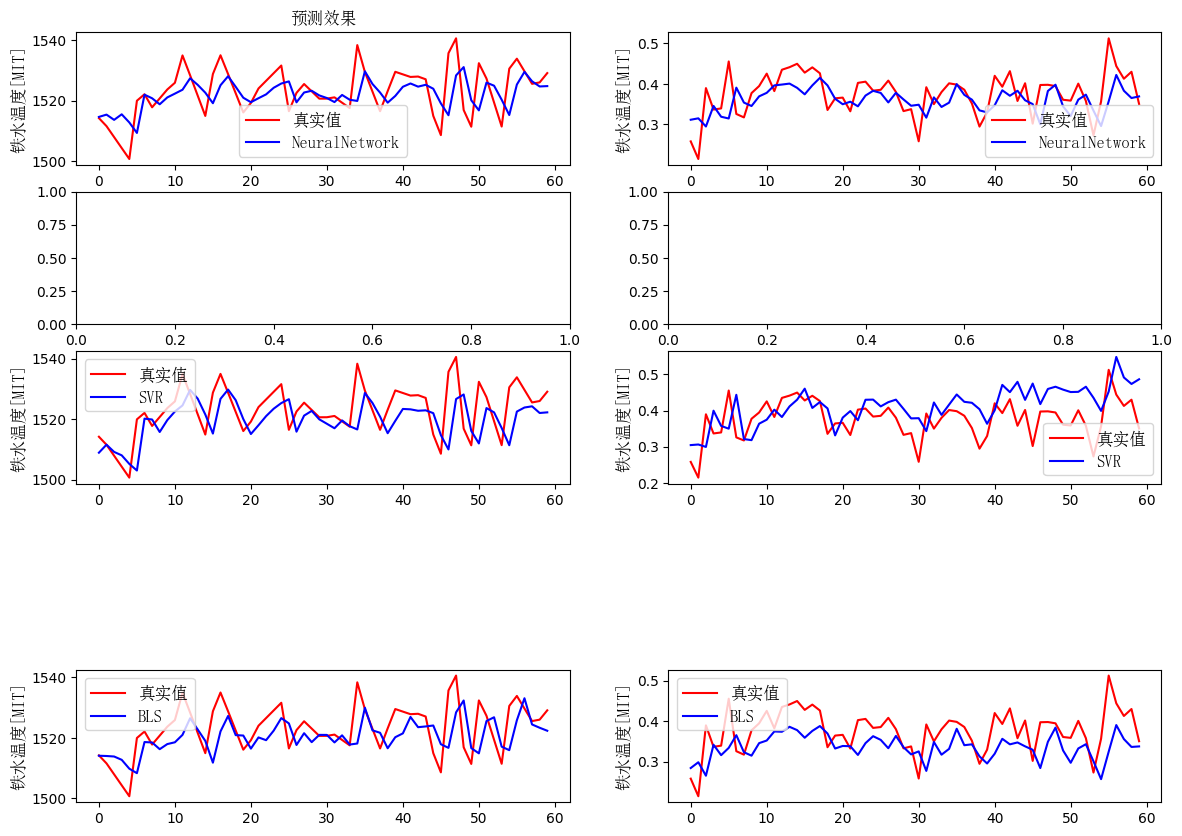

In [35]:
plt.figure(figsize=(14, 10))
plt.subplot(5, 2, 1)
plt.plot(y_test_0,'r', label="真实值")
plt.plot(NeuralNetwork_0,'b', label="NeuralNetwork")
plt.ylabel(output_term[0], fontproperties=font)
plt.legend(prop=font)
plt.title("预测效果", fontproperties=font)

plt.subplot(5, 2, 3)
# plt.plot(y_test_0,'r', label="真实值")
# plt.plot(LSTM_0,'b', label="LSTM")
# plt.ylabel(output_term[0], fontproperties=font)
# plt.legend(prop=font)

plt.subplot(5, 2, 5)
plt.plot(y_test_0,'r', label="真实值")
plt.plot(SVR_0,'b', label="SVR")
plt.ylabel(output_term[0], fontproperties=font)
plt.legend(prop=font)



plt.subplot(5, 2, 9)
plt.plot(y_test_0,'r', label="真实值")
plt.plot(BLS_0,'b', label="BLS")
plt.ylabel(output_term[0], fontproperties=font)
plt.legend(prop=font)



plt.subplot(5, 2, 2)
plt.plot(y_test_1,'r', label="真实值")
plt.plot(NeuralNetwork_1,'b', label="NeuralNetwork")
plt.ylabel(output_term[0], fontproperties=font)
plt.legend(prop=font)

plt.subplot(5, 2, 4)
# plt.plot(y_test_1,'r', label="真实值")
# plt.plot(LSTM_1,'b', label="LSTM")
# plt.ylabel(output_term[0], fontproperties=font)
# plt.legend(prop=font)

plt.subplot(5, 2, 6)
plt.plot(y_test_1,'r', label="真实值")
plt.plot(SVR_1,'b', label="SVR")
plt.ylabel(output_term[0], fontproperties=font)
plt.legend(prop=font)



plt.subplot(5, 2, 10)
plt.plot(y_test_1,'r', label="真实值")
plt.plot(BLS_1,'b', label="BLS")
plt.ylabel(output_term[0], fontproperties=font)
plt.legend(prop=font)




In [36]:
def data_fenxi(scalers,output_term,
                y_test,y_pred_0,y_pred_1,
                y_test_2,y_pred_0_2,y_pred_1_2):
    # y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
    # y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()
    # y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
    # y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

    # rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
    # rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

    # mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))
    # mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1))

    # mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
    # mape_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) * 100

    # percent0 = np.sum(np.fabs(y_test_0 - y_pred_0_inverse_transform) < 10)/len(y_test_0)
    # percent1 = np.sum(np.fabs(y_test_1 - y_pred_1_inverse_transform) < 0.1)/len(y_test_1)
    # print('训练集')



    y_test_0 = scalers[output_term[0]].inverse_transform((y_test_2[:, 0]).reshape(-1, 1)).flatten()
    y_test_1 = scalers[output_term[1]].inverse_transform((y_test_2[:, 1]).reshape(-1, 1)).flatten()
    y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0_2).reshape(-1, 1)).flatten()
    y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1_2).reshape(-1, 1)).flatten()

    rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
    rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

    mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))
    mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1))


    mae_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform)))
    mae_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform)))

    percent0 = np.sum(np.fabs(y_test_0 - y_pred_0_inverse_transform) < 10)/len(y_test_0)
    percent1 = np.sum(np.fabs(y_test_1 - y_pred_1_inverse_transform) < 0.1)/len(y_test_1)


    R2_0 = r2_score(y_pred_0_inverse_transform, y_test_0)
    R2_1 = r2_score(y_pred_1_inverse_transform, y_test_1)

    # 打印结果
    print('测试集')
    print(f"RMSE   :  {output_term[0]}: {rmse_0:.4f} , {output_term[1]}: {rmse_1:.4f} ")
    print(f"MAE   :  {output_term[0]}: {mae_0:.4f} , {output_term[1]}: {mae_1:.4f}")
    print(f"MRE    :  {output_term[0]}: { mre_0:.4f}  , {output_term[1]}: { mre_1:.4f} ")
    print(f"percent:  {output_term[0]}: { percent0:.4f}  , {output_term[1]}: { percent1:.4f} ")
    # print(f"R2     :  {output_term[0]}: { R2_0:.4f}  , {output_term[1]}: { R2_1:.4f} ")


    
    print('测试集')
    print(f"{rmse_0:.4f} {rmse_1:.4f} ")
    print(f"{mae_0:.4f} {mae_1:.4f}")
    print(f"{ mre_0:.4f} { mre_1:.4f} ")
    print(f"{ percent0:.4f} { percent1:.4f} ")


    # print(f"per :  {output_term[0]}: { percent0:.4f}  , {output_term[1]}: { percent1:.4f} ---")


In [37]:
print('NeuralNetwork')
data_fenxi(scalers,  output_term,
                                        y_predict_train,  NeuralNetwork_y_train_pred_0, NeuralNetwork_y_train_pred_1,
                                        y_predict_test ,  NeuralNetwork_y_test_pred_0 , NeuralNetwork_y_test_pred_1)

# print('LSTM')
# data_fenxi(scalers,  output_term,
#                                         y_predict_train,  LSTM_y_train_pred_0, LSTM_y_train_pred_1,
#                                         y_predict_test,   LSTM_y_test_pred_0,  LSTM_y_test_pred_1)

print('SVR')
data_fenxi(scalers,  output_term,
                                        y_predict_train,  SVR_y_train_pred_0, SVR_y_train_pred_1,
                                        y_predict_test,   SVR_y_test_pred_0,  SVR_y_test_pred_1)


print('BLS')
data_fenxi(scalers,  output_term,
                                        y_predict_train,  BLS_y_train_pred_0, BLS_y_train_pred_1,
                                        y_predict_test,   BLS_y_test_pred_0,  BLS_y_test_pred_1)


NeuralNetwork
测试集
RMSE   :  铁水温度[MIT]: 7.4358 , 铁水硅含量[SI]: 0.0516 
MAE   :  铁水温度[MIT]: 5.5973 , 铁水硅含量[SI]: 0.0400
MRE    :  铁水温度[MIT]: 0.0037  , 铁水硅含量[SI]: 0.1092 
percent:  铁水温度[MIT]: 0.8167  , 铁水硅含量[SI]: 0.9500 
测试集
7.4358 0.0516 
5.5973 0.0400
0.0037 0.1092 
0.8167 0.9500 
SVR
测试集
RMSE   :  铁水温度[MIT]: 8.2690 , 铁水硅含量[SI]: 0.0697 
MAE   :  铁水温度[MIT]: 6.2291 , 铁水硅含量[SI]: 0.0580
MRE    :  铁水温度[MIT]: 0.0041  , 铁水硅含量[SI]: 0.1655 
percent:  铁水温度[MIT]: 0.8000  , 铁水硅含量[SI]: 0.8333 
测试集
8.2690 0.0697 
6.2291 0.0580
0.0041 0.1655 
0.8000 0.8333 
BLS
测试集
RMSE   :  铁水温度[MIT]: 7.9083 , 铁水硅含量[SI]: 0.0627 
MAE   :  铁水温度[MIT]: 6.1167 , 铁水硅含量[SI]: 0.0506
MRE    :  铁水温度[MIT]: 0.0040  , 铁水硅含量[SI]: 0.1317 
percent:  铁水温度[MIT]: 0.8333  , 铁水硅含量[SI]: 0.9000 
测试集
7.9083 0.0627 
6.1167 0.0506
0.0040 0.1317 
0.8333 0.9000 
